In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.cross_validation as cross_validation
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from IPython.core.pylabtools import figsize

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load local csv data into pandas DataFrame
passenger_df = pd.read_csv("data/train.csv")

print list(passenger_df)
print passenger_df.shape
passenger_df.sample(5)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
636,637,0,3,"Leinonen, Mr. Antti Gustaf",male,32.0,0,0,STON/O 2. 3101292,7.9250,NaN,S
393,394,1,1,"Newell, Miss. Marjorie",female,23.0,1,0,35273,113.2750,D36,C
660,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0000,B96 B98,S
367,368,1,3,"Moussa, Mrs. (Mantoura Boulos)",female,NaN,0,0,2626,7.2292,NaN,C


In [3]:
def summerize_data(df):
    for column in df.columns:
        print column
        if df.dtypes[column] == np.object: # Categorical data
            print df[column].value_counts()
        else:
            print df[column].describe() 
            
        print '\n'
summerize_data(passenger_df)

PassengerId
count    891.000000
mean     446.000000
std      257.353842
min        1.000000
25%      223.500000
50%      446.000000
75%      668.500000
max      891.000000
Name: PassengerId, dtype: float64


Survived
count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64


Pclass
count    891.000000
mean       2.308642
std        0.836071
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64


Name
Graham, Mr. George Edward                                  1
Elias, Mr. Tannous                                         1
Madill, Miss. Georgette Alexandra                          1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)        1
Beane, Mrs. Edward (Ethel Clarke)                          1
Roebling, Mr. Washington Augustus II                       1
Moran, Mr. James     

In [4]:
# After a quick glance of the raw data, let us drop the "cabin" column 'cause there are too many data points missing
# Also drop the "ticket" column because the values are a mix of numbers and strings, and they doesn't seem to contain obvious patterns
new_df = passenger_df.copy()

del new_df["Cabin"]
del new_df["Ticket"]

# Drop the "Name" column for now, unless we come up with some clever way to analyze them
del new_df["Name"]

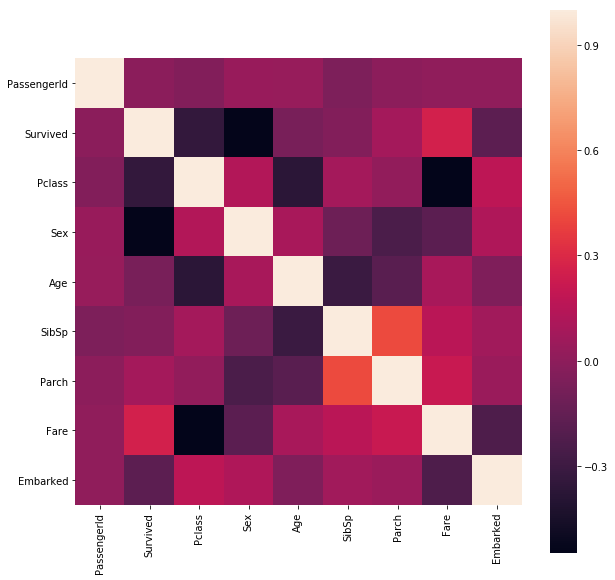

In [5]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders


# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(new_df)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(encoded_data.corr(), square=True, ax=ax)
plt.show()

In [6]:
# Fill the missing values in the "Age" column with mean values
encoded_data=encoded_data.fillna(encoded_data.mean())

In [7]:
new_series = encoded_data["Survived"]
# Split and scale the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(encoded_data[encoded_data.columns.drop("Survived")], new_series, train_size=0.75)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)
# logistic regression
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
print accuracy_score(y_test, y_pred)

0.7937219730941704


Index([u'PassengerId', u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare',
       u'Embarked'],
      dtype='object')


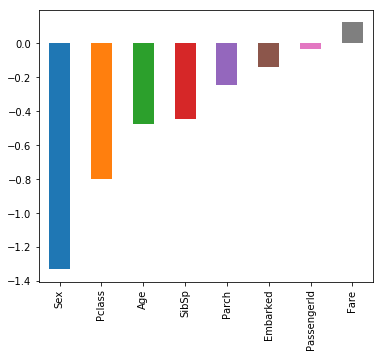

Sex           -1.334001
Pclass        -0.798389
Age           -0.478159
SibSp         -0.447465
Parch         -0.245757
Embarked      -0.137576
PassengerId   -0.033752
Fare           0.123459
dtype: float64


In [8]:
figsize(6, 5) 
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print X_train.columns
coefs = coefs.sort_values()
plt.subplot(1,1,1)
coefs.plot(kind="bar")
plt.show()
print coefs.sort_values(ascending = True)

In [9]:
new_df=new_df.fillna(new_df.mean())

# Select the numeric columns 
numeric_subset = new_df.select_dtypes('number')
numeric_subset = numeric_subset[numeric_subset.columns.drop("Survived")]

categorical_subset = new_df.select_dtypes('object')

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

In [10]:
# Split and scale the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

In [11]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
print accuracy_score(y_test, y_pred)

0.7761194029850746


1    233
0     81
Name: Survived, dtype: int64


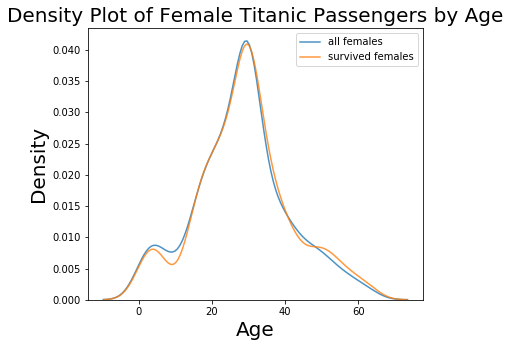

In [12]:
figsize(6, 5) 

# Split the survived passengers to male and female
males = new_df[new_df['Sex'] == 'male']
survived_males = new_df[(new_df['Sex']=='male')&(new_df['Survived']==1)]

females = new_df[new_df['Sex'] == 'female']
survived_females = new_df[(new_df['Sex']=='female')&(new_df['Survived']==1)]

print females["Survived"].value_counts()

sns.kdeplot(females['Age'],
               label = 'all females', shade = False, alpha = 0.8);
sns.kdeplot(survived_females['Age'],
               label = 'survived females', shade = False, alpha = 0.8);
# label the plot
plt.xlabel('Age', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Female Titanic Passengers by Age', size = 20);


0    468
1    109
Name: Survived, dtype: int64


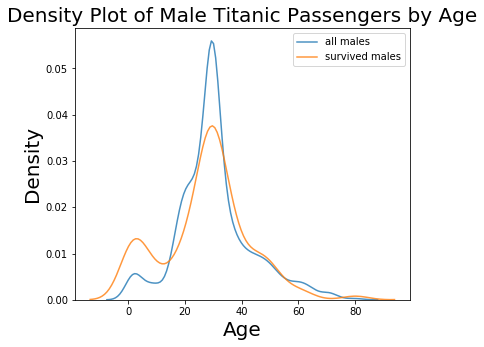

In [13]:
figsize(6, 5) 

print males["Survived"].value_counts()

sns.kdeplot(males['Age'],
               label = 'all males', shade = False, alpha = 0.8);
sns.kdeplot(survived_males['Age'],
               label = 'survived males', shade = False, alpha = 0.8);
# label the plot
plt.xlabel('Age', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Male Titanic Passengers by Age', size = 20);

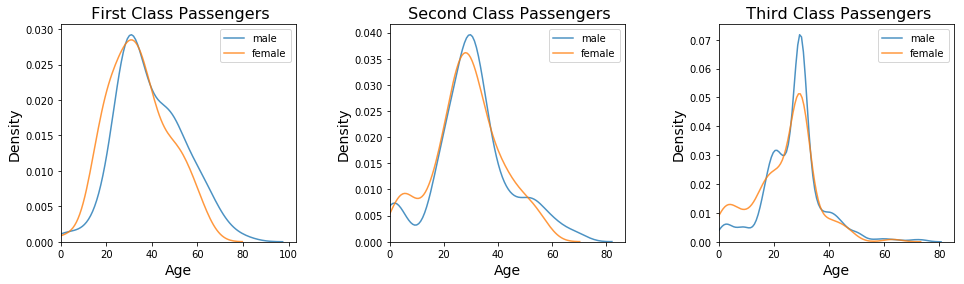

In [14]:
# Set-up 3x2 grid for plotting.
figsize(16, 4)
fig, sub = plt.subplots(1,3)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

titles = [" First Class "," Second Class "," Third Class "]

for i, title, ax in zip([1,2,3], titles, sub.flatten()):
    male_data = males[males['Pclass']==i]
    female_data = females[females['Pclass']==i]
    
    plt_title = title + 'Passengers'
    sns.kdeplot(male_data['Age'],
               label = 'male', shade = False, alpha = 0.8,ax=ax);
    sns.kdeplot(female_data['Age'],
               label = 'female', shade = False, alpha = 0.8, ax=ax)
    
    ax.set_xlabel('Age', size = 14)
    ax.set_ylabel('Density', size = 14)
    ax.set_title(plt_title, size = 16)
    ax.set(xlim=(0))
  
plt.show()

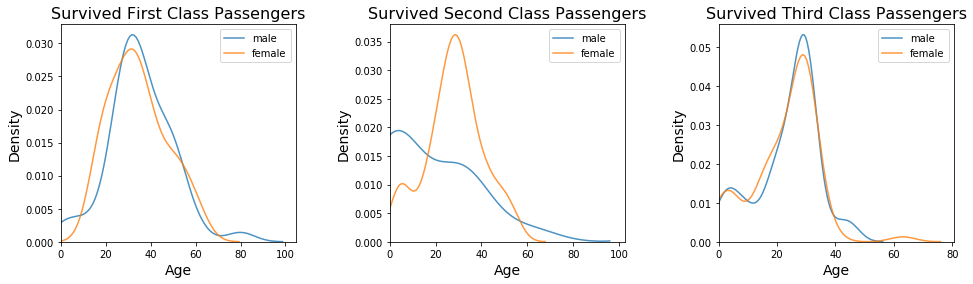

In [15]:
# Set-up 3x2 grid for plotting.
figsize(16, 4)
fig, sub = plt.subplots(1,3)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

titles = [" First Class "," Second Class "," Third Class "]

for i, title, ax in zip([1,2,3], titles, sub.flatten()):
    male_data = survived_males[survived_males['Pclass']==i]
    female_data = survived_females[survived_females['Pclass']==i]
    
    plt_title = 'Survived'+ title + 'Passengers'
    sns.kdeplot(male_data['Age'],
               label = 'male', shade = False, alpha = 0.8,ax=ax);
    ax.set_xlabel('Age', size = 14)
    sns.kdeplot(female_data['Age'],
               label = 'female', shade = False, alpha = 0.8, ax=ax)
    ax.set_xlabel('Age', size = 14)
    ax.set_ylabel('Density', size = 14)
    ax.set_title(plt_title, size = 16)
    ax.set(xlim=(0))
  
plt.show()

In [16]:
# Split passengers by class
print new_df.groupby(["Pclass", "Survived","Sex"]).size()

Pclass  Survived  Sex   
1       0         female      3
                  male       77
        1         female     91
                  male       45
2       0         female      6
                  male       91
        1         female     70
                  male       17
3       0         female     72
                  male      300
        1         female     72
                  male       47
dtype: int64
